## **Data Understanding**

Dataset Facial Expression Recognition (FER)
- Dataset ini berisi gambar wajah berukuran 48x48 piksel dalam skala keabuan (grayscale).
- Setiap wajah sudah melalui proses registrasi otomatis sehingga posisi wajah relatif seragam.
- Tugas utama adalah mengklasifikasikan ekspresi wajah ke dalam 7 kategori emosi:
    0 = Angry
    1 = Disgust
    2 = Fear
    3 = Happy
    4 = Sad
    5 = Surprise
    6 = Neutral
- Jumlah data:
    * Training set: 28.709 gambar
    * Test set: 3.589 gambar

Tujuan:
- Melatih model CNN untuk mengenali ekspresi wajah manusia.
- Mengevaluasi kinerja model dengan classification report dan confusion matrix.
- Melakukan inference untuk beberapa gambar uji acak.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

In [2]:
TRAIN_DIR = "data/train"
TEST_DIR = "data/test"
IMG_SIZE = (48, 48)
TL_IMG_SIZE = (96, 96)
BATCH_SIZE = 128
SEED = 2025
EPOCHS_BASELINE = 30
EPOCHS_TL = 30
MODEL_A_PATH = "model/fer_model_baseline.h5"
MODEL_B_PATH = "model/fer_model_mobilenet.h5"

In [3]:
# Fix seeds for reproducibility
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## **Data Preparation**

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    label_mode='int'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    label_mode='int'
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [6]:
def plot_history(hists, titles=None):
    # hists: list of history.history dicts
    n = len(hists)
    plt.figure(figsize=(12,4))
    for i, hist in enumerate(hists):
        plt.subplot(1,2,1)
        plt.plot(hist['loss'], label=(titles[i] + ' train') if titles else f'{i} train')
        plt.plot(hist['val_loss'], label=(titles[i] + ' val') if titles else f'{i} val')

        plt.subplot(1,2,2)
        plt.plot(hist['accuracy'], label=(titles[i] + ' train') if titles else f'{i} train')
        plt.plot(hist['val_accuracy'], label=(titles[i] + ' val') if titles else f'{i} val')

    plt.subplot(1,2,1)
    plt.title('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.title('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()


def evaluate_and_report(model, dataset, class_names):
    y_true = []
    y_pred = []
    for x_batch, y_batch in dataset:
        preds = model.predict(x_batch)
        preds_labels = np.argmax(preds, axis=1)
        y_true.extend(y_batch.numpy().tolist())
        y_pred.extend(preds_labels.tolist())

    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    cm = confusion_matrix(y_true, y_pred)
    return report, cm


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else int(cm[i,j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## **Modelling**

### Model A: Baseline CNN

In [8]:
def build_baseline_cnn(input_shape=(*IMG_SIZE,1), num_classes=num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='swish')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name='baseline_cnn')
    return model

model_a = build_baseline_cnn()
model_a.compile(optimizer=keras.optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_a.summary()

Model: "baseline_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)       

In [ ]:
callbacks_a = [
    keras.callbacks.ModelCheckpoint(MODEL_A_PATH, save_best_only=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1618, patience=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

history_a = model_a.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_BASELINE, callbacks=callbacks_a)

Epoch 1/30
225/225 [==============================] - 9s 33ms/step - loss: 1.7122 - accuracy: 0.3111 - val_loss: 1.9812 - val_accuracy: 0.2629 - lr: 0.0010
Epoch 2/30
225/225 [==============================] - 7s 29ms/step - loss: 1.4448 - accuracy: 0.4445 - val_loss: 2.1990 - val_accuracy: 0.2686 - lr: 0.0010
Epoch 3/30
225/225 [==============================] - 7s 32ms/step - loss: 1.3173 - accuracy: 0.4994 - val_loss: 1.6569 - val_accuracy: 0.3610 - lr: 0.0010
Epoch 4/30
225/225 [==============================] - 7s 31ms/step - loss: 1.2406 - accuracy: 0.5305 - val_loss: 1.6496 - val_accuracy: 0.4117 - lr: 0.0010
Epoch 5/30
225/225 [==============================] - 7s 30ms/step - loss: 1.1833 - accuracy: 0.5494 - val_loss: 1.2536 - val_accuracy: 0.5216 - lr: 0.0010
Epoch 6/30
225/225 [==============================] - 7s 30ms/step - loss: 1.1296 - accuracy: 0.5728 - val_loss: 1.2529 - val_accuracy: 0.5318 - lr: 0.0010
Epoch 7/30
225/225 [==============================] - 7s 31ms/st

### Model B: Transfer Learning (MobileNetV2)

In [10]:
# Prepare datasets for TL: create new datasets that resize and convert to RGB

def preprocess_for_tl(image, label):
    # image: grayscale [H,W,1], convert to RGB and resize
    img = tf.image.resize(image, TL_IMG_SIZE)
    img = tf.image.grayscale_to_rgb(img)  # replicate channels
    img = img / 255.0
    return img, label

train_ds_tl = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    label_mode='int'
).map(preprocess_for_tl, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).prefetch(AUTOTUNE)

val_ds_tl = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    label_mode='int'
).map(preprocess_for_tl, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [ ]:
# Build TL model
base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(*TL_IMG_SIZE,3), weights='imagenet')
base_model.trainable = False  # freeze initially

inputs = keras.Input(shape=(*TL_IMG_SIZE,3))
x = base_model(inputs, training=False)
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='swish')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_b = keras.Model(inputs, outputs, name='mobilenetv2_tl')
model_b.compile(optimizer=keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_b.summary()

Model: "mobilenetv2_tl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 128)         1474688   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 1, 128)        0         
 2D)                                                             
                                                                 
 global_average_pooling2d_1   (None, 128)              0         
 (GlobalAveragePooling2D)                                        
                                                    

In [12]:
callbacks_b = [
    keras.callbacks.ModelCheckpoint(MODEL_B_PATH, save_best_only=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1618, patience=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

history_b = model_b.fit(train_ds_tl, validation_data=val_ds_tl, epochs=EPOCHS_TL, callbacks=callbacks_b)

Epoch 1/30
225/225 [==============================] - 26s 73ms/step - loss: 1.6643 - accuracy: 0.3535 - val_loss: 1.4867 - val_accuracy: 0.4322 - lr: 1.0000e-04
Epoch 2/30
225/225 [==============================] - 14s 63ms/step - loss: 1.4896 - accuracy: 0.4262 - val_loss: 1.4046 - val_accuracy: 0.4700 - lr: 1.0000e-04
Epoch 3/30
225/225 [==============================] - 14s 64ms/step - loss: 1.4111 - accuracy: 0.4643 - val_loss: 1.3657 - val_accuracy: 0.4847 - lr: 1.0000e-04
Epoch 4/30
225/225 [==============================] - 14s 64ms/step - loss: 1.3515 - accuracy: 0.4846 - val_loss: 1.3462 - val_accuracy: 0.4958 - lr: 1.0000e-04
Epoch 5/30
225/225 [==============================] - 14s 63ms/step - loss: 1.2951 - accuracy: 0.5112 - val_loss: 1.3093 - val_accuracy: 0.5059 - lr: 1.0000e-04
Epoch 6/30
225/225 [==============================] - 14s 63ms/step - loss: 1.2434 - accuracy: 0.5316 - val_loss: 1.2892 - val_accuracy: 0.5183 - lr: 1.0000e-04
Epoch 7/30
225/225 [==============

In [13]:
# Optional: fine-tune top layers
base_model.trainable = True
# freeze until a certain layer
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [14]:
model_b.compile(optimizer=keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_ft = model_b.fit(train_ds_tl, validation_data=val_ds_tl, epochs=5, callbacks=callbacks_b)

Epoch 1/5
225/225 [==============================] - 31s 112ms/step - loss: 1.9511 - accuracy: 0.2370 - val_loss: 1.8240 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 2/5
225/225 [==============================] - 23s 104ms/step - loss: 1.8137 - accuracy: 0.2513 - val_loss: 1.8132 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 3/5
225/225 [==============================] - 23s 103ms/step - loss: 1.8101 - accuracy: 0.2513 - val_loss: 1.8134 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 4/5
225/225 [==============================] - 23s 103ms/step - loss: 1.8102 - accuracy: 0.2513 - val_loss: 1.8143 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 5/5
225/225 [==============================] - 23s 103ms/step - loss: 1.8103 - accuracy: 0.2513 - val_loss: 1.8138 - val_accuracy: 0.2471 - lr: 0.0010


## **Evaluation**

### Model A: Baseline CNN

1/1 [==============================] - 0s 153ms/step

===== BASELINE CNN REPORT =====

              precision    recall  f1-score   support

       angry     0.5161    0.4854    0.5003       958
     disgust     0.8333    0.3153    0.4575       111
        fear     0.4566    0.3291    0.3825      1024
       happy     0.7680    0.8191    0.7927      1774
     neutral     0.5101    0.5734    0.5399      1233
         sad     0.4523    0.5172    0.4826      1247
    surprise     0.7730    0.7377    0.7549       831

    accuracy                         0.5928      7178
   macro avg     0.6156    0.5396    0.5586      7178
weighted avg     0.5924    0.5928    0.5883      7178



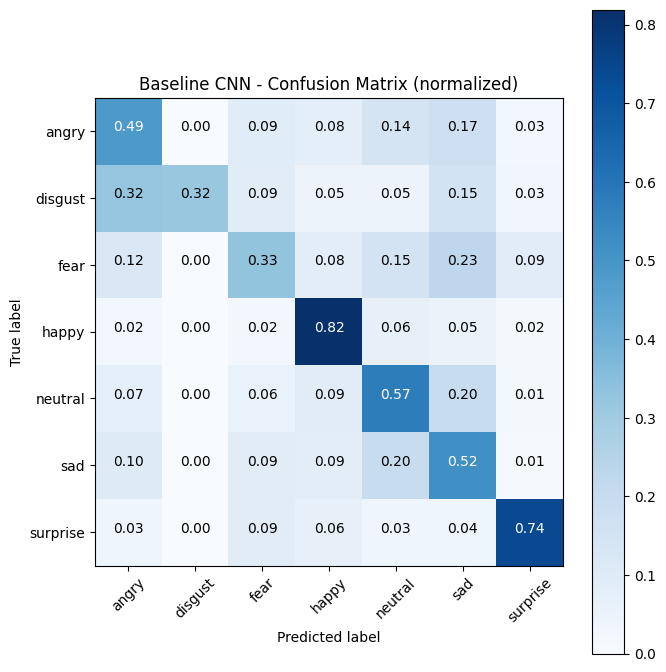

In [15]:
# load best
if os.path.exists(MODEL_A_PATH):
    model_a = keras.models.load_model(MODEL_A_PATH)
report_a, cm_a = evaluate_and_report(model_a, val_ds, class_names)
print('\n===== BASELINE CNN REPORT =====\n')
print(report_a)
plot_confusion_matrix(cm_a, class_names, normalize=True, title='Baseline CNN - Confusion Matrix (normalized)')

### Model B: Transfer Learning (MobileNetV2)

1/1 [==============================] - 1s 1s/step

===== MOBILENETV2 TL REPORT =====

              precision    recall  f1-score   support

       angry     0.4801    0.3779    0.4229       958
     disgust     0.8571    0.2703    0.4110       111
        fear     0.4787    0.3408    0.3982      1024
       happy     0.6642    0.7593    0.7086      1774
     neutral     0.4922    0.5134    0.5026      1233
         sad     0.4092    0.4932    0.4473      1247
    surprise     0.6975    0.7076    0.7025       831

    accuracy                         0.5467      7178
   macro avg     0.5827    0.4946    0.5133      7178
weighted avg     0.5462    0.5467    0.5401      7178



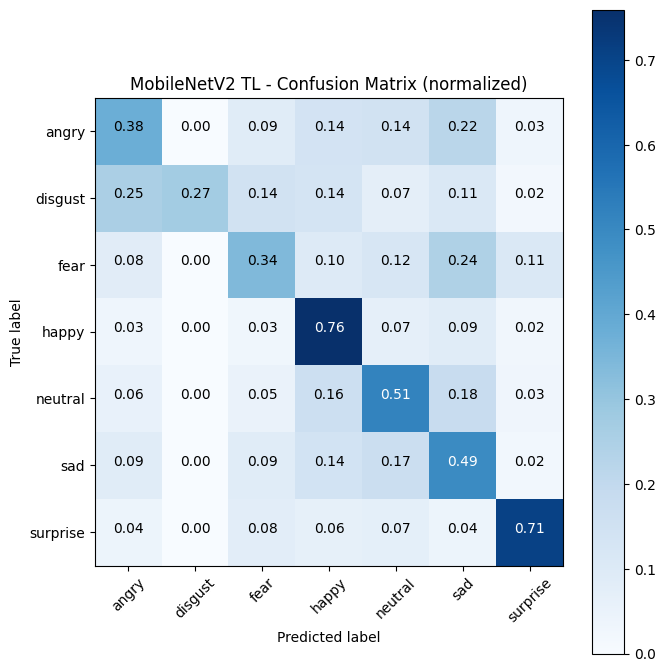

In [16]:
# load best
if os.path.exists(MODEL_B_PATH):
    model_b = keras.models.load_model(MODEL_B_PATH)

report_b, cm_b = evaluate_and_report(model_b, val_ds_tl, class_names)
print('\n===== MOBILENETV2 TL REPORT =====\n')
print(report_b)
plot_confusion_matrix(cm_b, class_names, normalize=True, title='MobileNetV2 TL - Confusion Matrix (normalized)')


### Summary


===== SUMMARY COMPARISON =====

Baseline model path: model/fer_model_baseline.h5
TL model path: model/fer_model_mobilenet.h5

Baseline Classification Report:

              precision    recall  f1-score   support

       angry     0.5161    0.4854    0.5003       958
     disgust     0.8333    0.3153    0.4575       111
        fear     0.4566    0.3291    0.3825      1024
       happy     0.7680    0.8191    0.7927      1774
     neutral     0.5101    0.5734    0.5399      1233
         sad     0.4523    0.5172    0.4826      1247
    surprise     0.7730    0.7377    0.7549       831

    accuracy                         0.5928      7178
   macro avg     0.6156    0.5396    0.5586      7178
weighted avg     0.5924    0.5928    0.5883      7178


MobilenetV2 TL Classification Report:

              precision    recall  f1-score   support

       angry     0.4801    0.3779    0.4229       958
     disgust     0.8571    0.2703    0.4110       111
        fear     0.4787    0.3408    0.3

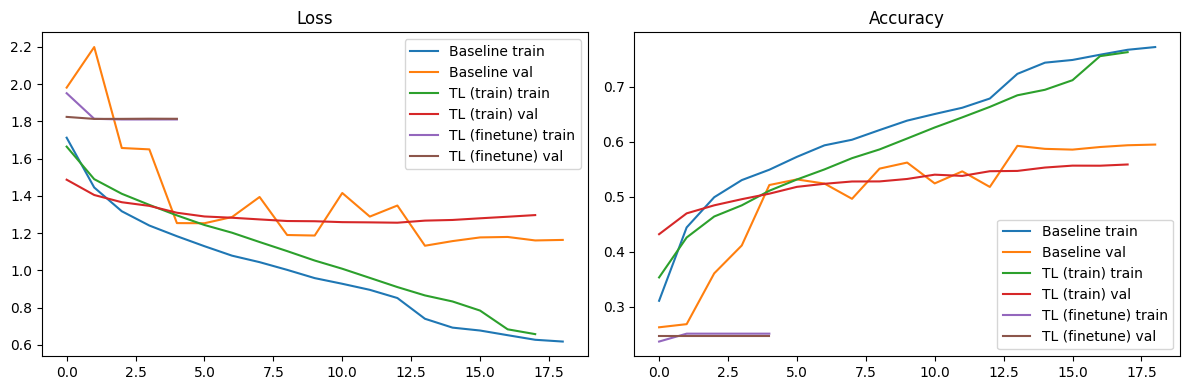

In [17]:
print('\n===== SUMMARY COMPARISON =====\n')
print('Baseline model path:', MODEL_A_PATH)
print('TL model path:', MODEL_B_PATH)

print('\nBaseline Classification Report:\n')
print(report_a)
print('\nMobilenetV2 TL Classification Report:\n')
print(report_b)

# Plot histories
plot_history([history_a.history, history_b.history, history_ft.history], titles=['Baseline','TL (train)','TL (finetune)'])

## **Inference**

1/1 [==============================] - 0s 263ms/step
True: angry | Baseline pred: angry | TL pred: angry


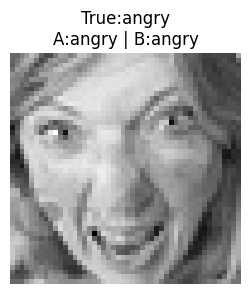

1/1 [==============================] - 0s 37ms/step
True: disgust | Baseline pred: angry | TL pred: angry


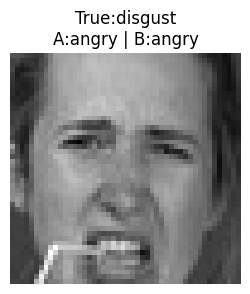

1/1 [==============================] - 0s 40ms/step
True: fear | Baseline pred: angry | TL pred: neutral


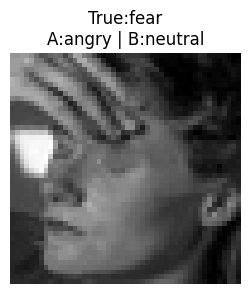

1/1 [==============================] - 0s 33ms/step
True: happy | Baseline pred: angry | TL pred: happy


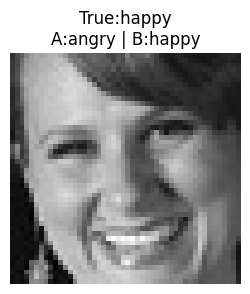

1/1 [==============================] - 0s 42ms/step
True: neutral | Baseline pred: angry | TL pred: neutral


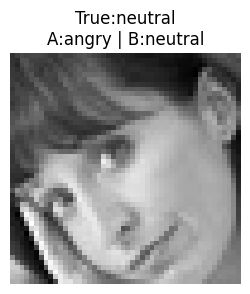

1/1 [==============================] - 0s 35ms/step
True: sad | Baseline pred: angry | TL pred: sad


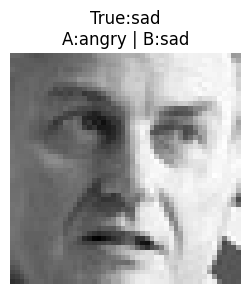

1/1 [==============================] - 0s 31ms/step
True: surprise | Baseline pred: angry | TL pred: neutral


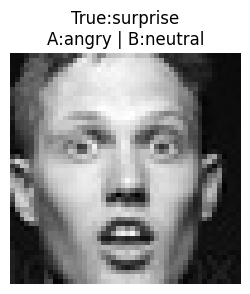

Selesai eksperimen.


In [18]:
from tensorflow.keras.preprocessing import image

random.seed(SEED)
images_per_class = {}
for cls in class_names:
    folder = Path(TEST_DIR) / cls
    all_files = list(folder.glob('*.jpg')) + list(folder.glob('*.png'))
    if len(all_files)==0:
        continue
    images_per_class[cls] = random.choice(all_files)

for cls, img_path in images_per_class.items():
    img = image.load_img(str(img_path), target_size=IMG_SIZE, color_mode='grayscale')
    arr = image.img_to_array(img)/255.0
    arr_batch = np.expand_dims(arr, axis=0)

    pred_a = model_a.predict(arr_batch)
    pred_a_label = class_names[np.argmax(pred_a, axis=1)[0]]

    # prepare for TL
    img_tl = image.load_img(str(img_path), target_size=TL_IMG_SIZE, color_mode='rgb')
    arr_tl = image.img_to_array(img_tl)/255.0
    arr_tl_batch = np.expand_dims(arr_tl, axis=0)
    pred_b = model_b.predict(arr_tl_batch)
    pred_b_label = class_names[np.argmax(pred_b, axis=1)[0]]

    print(f"True: {cls} | Baseline pred: {pred_a_label} | TL pred: {pred_b_label}")

    plt.figure(figsize=(3,3))
    plt.imshow(arr.squeeze(), cmap='gray')
    plt.title(f'True:{cls}\nA:{pred_a_label} | B:{pred_b_label}')
    plt.axis('off')
    plt.show()

print('Selesai eksperimen.')

### **Analisis Perbandingan Kinerja Model untuk Klasifikasi Ekspresi Wajah**

#### **Ringkasan Eksekutif**

Eksperimen ini bertujuan untuk membandingkan dua pendekatan model *deep learning* dalam menyelesaikan kasus klasifikasi ekspresi wajah pada dataset FER. Terdapat 7 kelas emosi yang menjadi target klasifikasi. Dua model yang diimplementasikan adalah:

1.  **Model A (Baseline CNN):** Sebuah model Convolutional Neural Network (CNN) sederhana yang dibangun dari awal (*from scratch*).
2.  **Model B (Transfer Learning):** Sebuah model yang memanfaatkan arsitektur **MobileNetV2** yang telah dilatih sebelumnya pada dataset ImageNet, dengan pendekatan *transfer learning* dan *fine-tuning*.

Hasil eksperimen menunjukkan sebuah temuan yang menarik: **Model A (Baseline CNN) yang lebih sederhana secara tak terduga memberikan performa yang lebih baik daripada Model B (Transfer Learning) yang lebih kompleks.** Akurasi Model A mencapai **59.3%**, sementara Model B hanya mencapai **54.7%** pada set validasi. Analisis mendalam akan menguraikan kemungkinan penyebab dari hasil ini dan memberikan rekomendasi untuk perbaikan.

---

#### **Analisis Kinerja Model A (Baseline CNN)**

*   **Arsitektur:** Model ini terdiri dari tiga blok konvolusi (Conv2D -> BatchNormalization -> MaxPooling) dengan jumlah filter yang meningkat (32, 64, 128), diikuti oleh Global Average Pooling dan lapisan *fully-connected* dengan Dropout untuk regularisasi. Arsitektur ini cukup standar dan efisien untuk tugas klasifikasi gambar berukuran kecil.

*   **Hasil Evaluasi:**
    *   **Akurasi:** Mencapai **59.28%**, sebuah hasil yang cukup baik sebagai *baseline* untuk dataset FER yang dikenal menantang.
    *   **Kinerja per Kelas:**
        *   Model menunjukkan performa terbaik pada kelas **'happy' (F1-score 0.79)** dan **'surprise' (F1-score 0.75)**. Kedua ekspresi ini memiliki ciri visual yang sangat distingtif dan mudah dibedakan.
        *   Performa terlemah terlihat pada kelas **'fear' (F1-score 0.38)** dan **'disgust' (F1-score 0.46)**.
        *   **Insight pada Kelas 'Disgust'**: Meskipun F1-score rendah, *precision* untuk kelas 'disgust' sangat tinggi (0.83), namun *recall*-nya sangat rendah (0.32). Ini berarti, ketika model memprediksi 'disgust', prediksinya cenderung benar. Namun, model ini gagal mengenali sebagian besar gambar 'disgust' yang sebenarnya. Hal ini umum terjadi pada kelas dengan jumlah data yang sangat sedikit (class imbalance), di mana 'disgust' adalah kelas minoritas dalam dataset FER.

*   **Confusion Matrix:**
    *   Matriks kebingungan menunjukkan bahwa model sering salah mengklasifikasikan ekspresi yang mirip secara visual, seperti **'fear'** yang sering tertukar dengan **'sad'**, dan **'angry'** yang tertukar dengan **'sad'** atau **'neutral'**. Ini adalah hal yang wajar karena kemiripan fitur pada ekspresi-ekspresi tersebut.

---

#### **Analisis Kinerja Model B (Transfer Learning - MobileNetV2)**

*   **Arsitektur & Pendekatan:** Model ini menggunakan MobileNetV2 sebagai *base model* dengan bobot dari ImageNet. Lapisan dasar dibekukan (*frozen*) pada tahap awal pelatihan, dan hanya lapisan *classifier* tambahan yang dilatih. Terdapat juga tahap *fine-tuning* di mana sebagian lapisan dasar ikut dilatih. Perlu dicatat bahwa data input harus diubah dari *grayscale* menjadi RGB dan ukurannya diperbesar menjadi 96x96 sesuai kebutuhan MobileNetV2.

*   **Hasil Evaluasi:**
    *   **Akurasi:** Hanya mencapai **54.67%**, secara signifikan lebih rendah dari Model A.
    *   **Kinerja per Kelas:**
        *   Secara umum, F1-score untuk hampir semua kelas lebih rendah dibandingkan Model A.
        *   Meskipun menggunakan arsitektur yang lebih canggih, model ini kesulitan membedakan kelas-kelas sulit seperti **'angry'**, **'fear'**, dan **'sad'**, dengan F1-score yang lebih rendah dari baseline.
        *   Recall untuk kelas **'disgust'** bahkan lebih rendah (0.27) dibandingkan Model A, menunjukkan kesulitan yang lebih besar dalam mengidentifikasi kelas minoritas.

---

#### **Perbandingan Performa dan Insight Mendalam**

Kinerja superior dari Model A yang lebih sederhana dibandingkan Model B yang kompleks dapat dijelaskan oleh beberapa faktor krusial:

1.  **Domain Mismatch pada Transfer Learning:**
    MobileNetV2 dilatih pada dataset ImageNet yang berisi ribuan kelas objek berwarna dengan fitur yang sangat beragam. Sebaliknya, dataset FER sangat spesifik: gambar wajah *grayscale* berukuran kecil dan terpusat. Fitur-fitur kompleks yang dipelajari MobileNetV2 dari ImageNet (seperti tekstur bulu, warna mobil, bentuk bangunan) kemungkinan besar tidak relevan dan bahkan menjadi "noise" untuk tugas membedakan nuansa ekspresi wajah dalam gambar *grayscale*. Model A, yang dilatih dari awal, dapat mempelajari fitur-fitur yang lebih relevan langsung dari data FER.

2.  **Kegagalan pada Tahap Fine-Tuning:**
    Log pelatihan pada notebook menunjukkan bahwa tahap *fine-tuning* Model B mengalami kegagalan total. Akurasi menurun drastis dan *loss* meningkat tajam. Ini adalah indikasi kuat bahwa *learning rate* yang digunakan terlalu tinggi. Saat melakukan *fine-tuning*, bobot *pre-trained* yang sudah baik dapat "hancur" jika diperbarui dengan *learning rate* yang besar. *Learning rate* yang sangat kecil (misalnya `1e-5`) seharusnya digunakan. Meskipun model terbaik disimpan sebelum tahap ini, kegagalan ini menunjukkan bahwa optimasi untuk Model B belum maksimal.

3.  **Kompleksitas Model vs. Spesifisitas Data:**
    Model B jauh lebih besar dan kompleks. Untuk dataset yang relatif kecil dan homogen seperti FER, model yang lebih sederhana (Model A) seringkali lebih mudah untuk dilatih dan kurang rentan terhadap *overfitting*. Model A memiliki "kapasitas" yang lebih sesuai dengan kompleksitas data yang ada.

4.  **Inference Acak:**
    Pada tahap *inference*, terlihat bahwa kedua model dapat memprediksi dengan benar untuk kelas yang mudah ('angry', 'happy', 'sad'). Namun, untuk kelas yang lebih sulit ('disgust', 'fear', 'surprise'), prediksi mulai bervariasi dan seringkali salah. Menariknya, pada contoh 'happy', Model A salah memprediksi sebagai 'angry' sementara Model B benar. Sebaliknya, pada contoh 'surprise', Model A benar sementara Model B salah. Ini menunjukkan bahwa kedua model mempelajari representasi fitur yang berbeda.

---

#### **Kesimpulan dan Rekomendasi**

**Kesimpulan:**
Model CNN baseline yang dirancang khusus untuk dataset FER (Model A) menunjukkan kinerja yang lebih unggul (akurasi 59.3%) dibandingkan dengan pendekatan *transfer learning* menggunakan MobileNetV2 (Model B, akurasi 54.7%). Penyebab utamanya adalah **ketidaksesuaian domain** antara data pra-pelatihan (ImageNet) dan data target (FER), serta **implementasi *fine-tuning* yang kurang optimal** pada Model B. Eksperimen ini menjadi pengingat penting bahwa arsitektur yang lebih besar dan canggih tidak selalu menjamin hasil yang lebih baik, terutama jika tidak disesuaikan dengan karakteristik data secara cermat.

**Rekomendasi untuk Eksperimen Lanjutan:**

1.  **Optimalkan Proses Fine-Tuning Model B:** Ulangi tahap *fine-tuning* dengan **learning rate yang jauh lebih kecil** (misalnya `Adam(learning_rate=1e-5)`). Ini adalah langkah perbaikan yang paling krusial.

2.  **Implementasikan Data Augmentation:** Notebook ini belum menerapkan augmentasi data. Menambahkan augmentasi seperti rotasi kecil, pergeseran horizontal/vertikal, dan zoom pada data latih dapat secara signifikan meningkatkan robustisitas dan generalisasi kedua model.

3.  **Tangani Ketidakseimbangan Kelas (Class Imbalance):** Untuk meningkatkan performa pada kelas 'disgust' dan 'fear', terapkan teknik seperti **pembobotan kelas (*class weighting*)** pada fungsi *loss* (`class_weight` pada `model.fit`) atau *oversampling* pada kelas minoritas.

4.  **Eksplorasi Arsitektur Pre-trained yang Berbeda:** Coba model *pre-trained* lain yang mungkin lebih ringan atau memiliki arsitektur yang lebih cocok, seperti **EfficientNetB0** atau model yang secara spesifik dilatih untuk pengenalan wajah jika tersedia (*e.g.*, VGGFace).